In [14]:
from torch.utils.tensorboard import SummaryWriter
from network_models import CombinedModel
from image_parser import train_loader
import torch
from torch import device, cuda
import yaml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

from data_parser import adj_matrix, nodes

In [2]:
log_dir = "logs" 
writer = SummaryWriter(log_dir)

config = yaml.safe_load(open("config.yml"))
RETINA_MODEL = config["RETINA_MODEL"]
dev = device("cuda" if cuda.is_available() else "cpu")

In [3]:
model = CombinedModel(adj_matrix, nodes, RETINA_MODEL)
model.load_state_dict(torch.load("model_21runs.pth"), strict=False)
model.eval()

C:\Users\eudald\Desktop\doctorat\codi\connectome\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\eudald\Desktop\doctorat\codi\connectome\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CombinedModel(
  (retina_model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)

In [23]:
# Get a sample batch from the train_loader
sample_batch, _ = next(iter(train_loader))

# Move the sample batch and model to the device (GPU or CPU)
sample_batch = sample_batch.to(dev)
model = model.to(dev)

# Add the model graph to TensorBoard
writer.add_graph(model, sample_batch)

In [4]:
shared_weights = pd.DataFrame(model.connectome_model.shared_weights.cpu().data)

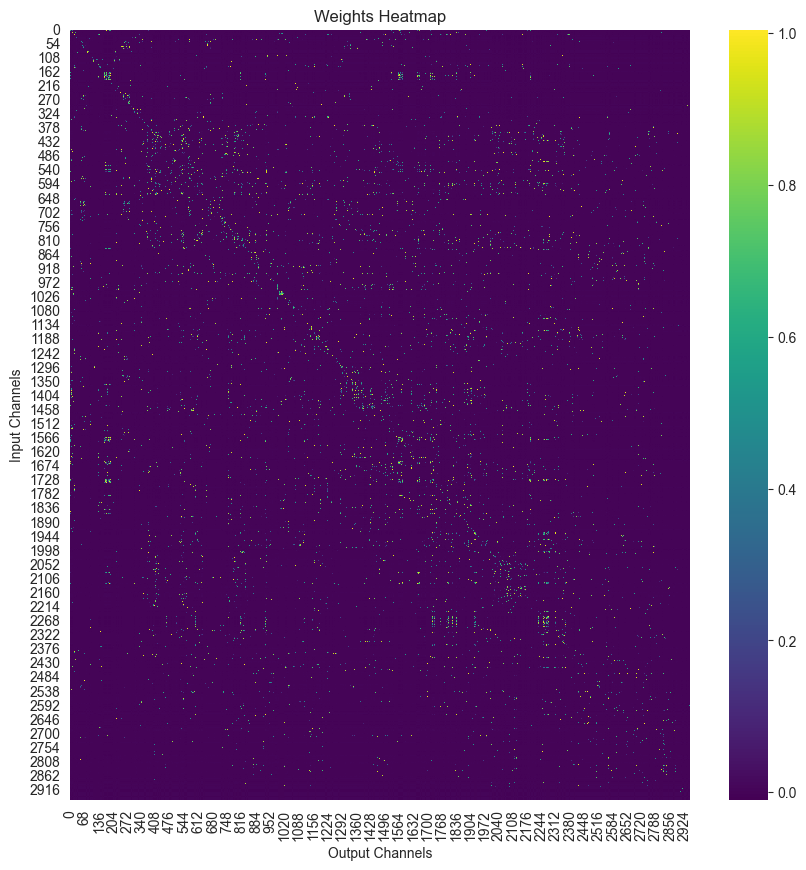

In [5]:
# Set the size of the heatmap
plt.figure(figsize=(10, 10))

# Plot the heatmap
sns.heatmap(shared_weights, cmap='viridis')

# Set the labels for the axes and the title of the heatmap
plt.xlabel('Output Channels')
plt.ylabel('Input Channels')
plt.title('Weights Heatmap')

# Show the heatmap
plt.show()

In [7]:
cor_matrix = shared_weights.corrwith(adj_matrix)

In [9]:
cor_matrix.mean()

IndexError: Inconsistent shape between the condition and the input (got (2952, 1) and (2952,))

<Figure size 1000x1000 with 0 Axes>

In [16]:
melted_A = pd.melt(shared_weights, var_name='column', value_name='value')
melted_B = pd.melt(adj_matrix, var_name='column', value_name='value')
correlation, pvalue = spearmanr(melted_A.values, melted_B.values)

In [17]:
correlation

array([[ 1.        , -0.00339126,  1.        , -0.01650067],
       [-0.00339126,  1.        , -0.00339126,  0.03701228],
       [ 1.        , -0.00339126,  1.        , -0.01650067],
       [-0.01650067,  0.03701228, -0.01650067,  1.        ]])

In [18]:
pvalue

array([[0.00000000e+00, 1.36341146e-23, 0.00000000e+00, 0.00000000e+00],
       [1.36341146e-23, 0.00000000e+00, 1.36341146e-23, 0.00000000e+00],
       [0.00000000e+00, 1.36341146e-23, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

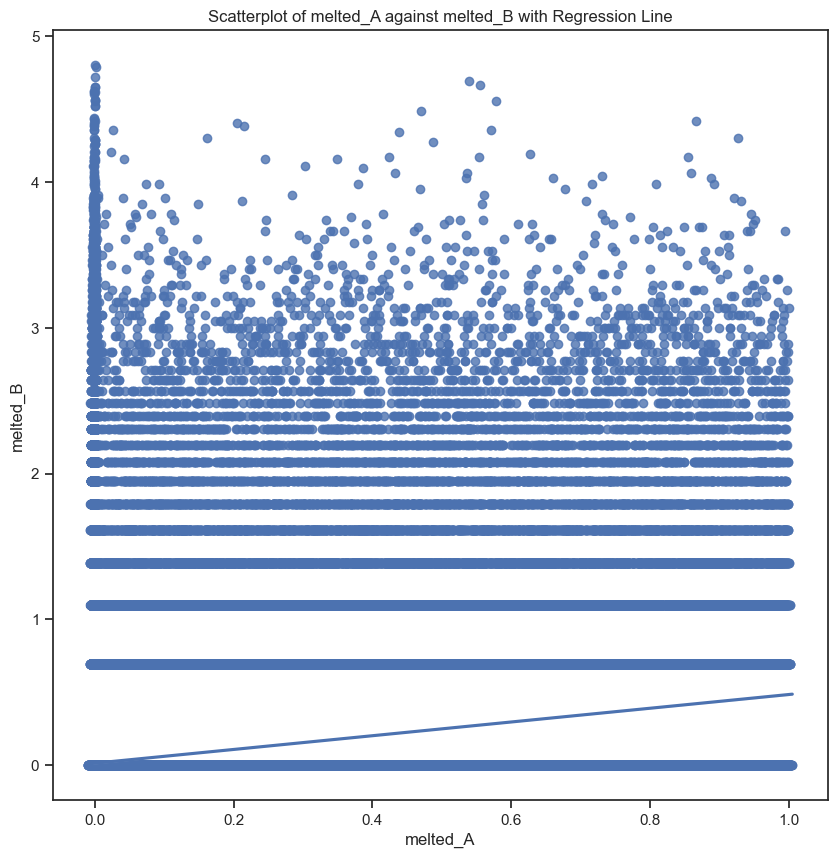

In [26]:
import numpy as np
# Create a new DataFrame with 'melted_A' and 'melted_B' as columns
scatter_data = pd.DataFrame({
    'melted_A': melted_A['value'],
    'melted_B': np.log(melted_B['value'] + 1)
})

# Plot the scatterplot with a regression line
sns.set(style="ticks")
plt.figure(figsize=(10, 10))
sns.regplot(x='melted_A', y='melted_B', data=scatter_data)
plt.xlabel('melted_A')
plt.ylabel('melted_B')
plt.title('Scatterplot of melted_A against melted_B with Regression Line')
plt.show()

